
Training Linear Regression...
Validation Set Evaluation for Linear Regression:
Mean Absolute Error (MAE): 17.297972332056343
Mean Squared Error (MSE): 1560.5204785901858
R-squared (R2): 0.46554714218819304

Test Set Evaluation for Linear Regression:
Mean Absolute Error (MAE): 18.125147751964796
Mean Squared Error (MSE): 1458.8963679736696
R-squared (R2): 0.4787319529294224


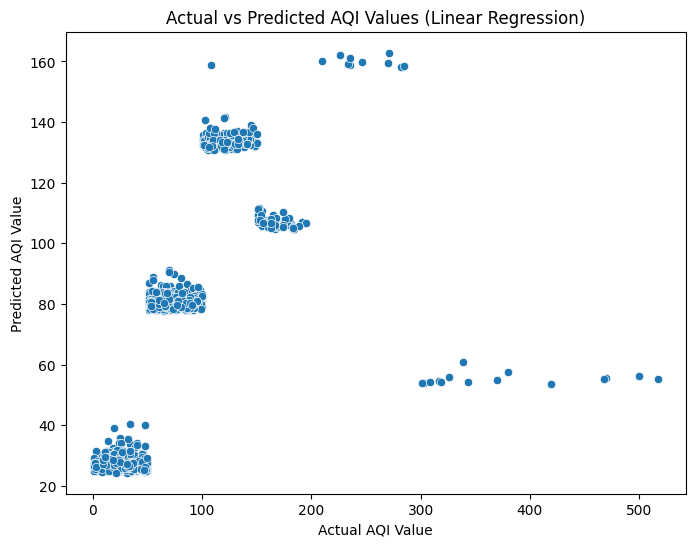


Training Ridge Regression...
Validation Set Evaluation for Ridge Regression:
Mean Absolute Error (MAE): 17.297698728415664
Mean Squared Error (MSE): 1560.5198674524988
R-squared (R2): 0.46554735149290116

Test Set Evaluation for Ridge Regression:
Mean Absolute Error (MAE): 18.124753943316374
Mean Squared Error (MSE): 1458.8928785905944
R-squared (R2): 0.4787331996964588


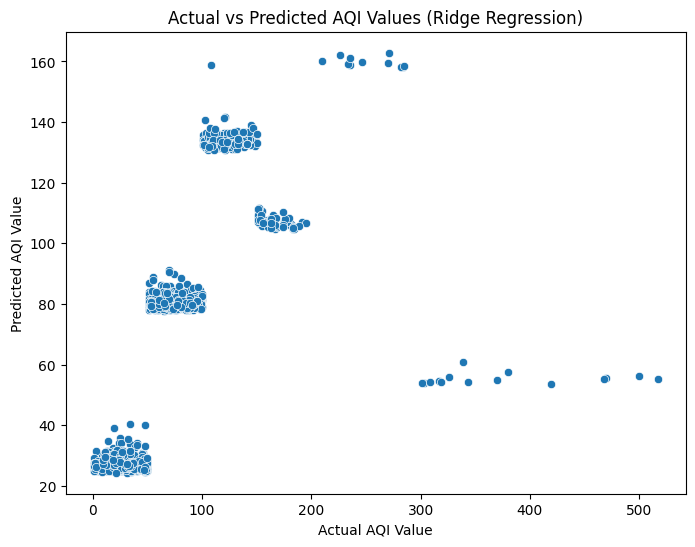


Training Random Forest Regressor...
Validation Set Evaluation for Random Forest Regressor:
Mean Absolute Error (MAE): 9.031927409261577
Mean Squared Error (MSE): 277.7574304130162
R-squared (R2): 0.9048726021225864

Test Set Evaluation for Random Forest Regressor:
Mean Absolute Error (MAE): 8.996797998749217
Mean Squared Error (MSE): 161.30920075046905
R-squared (R2): 0.9423637388538414


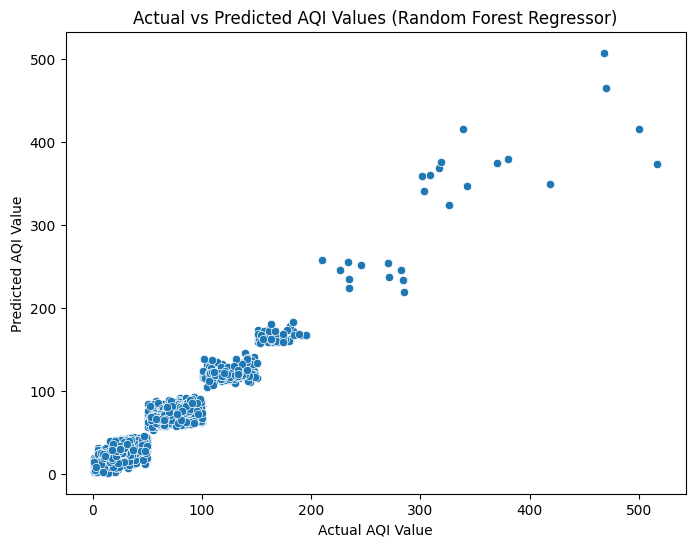


Model Comparison Results:
                         Validation MAE  Validation MSE  Validation R2  \
Linear Regression             17.297972     1560.520479       0.465547   
Ridge Regression              17.297699     1560.519867       0.465547   
Random Forest Regressor        9.031927      277.757430       0.904873   

                          Test MAE     Test MSE   Test R2  
Linear Regression        18.125148  1458.896368  0.478732  
Ridge Regression         18.124754  1458.892879  0.478733  
Random Forest Regressor   8.996798   161.309201  0.942364  

Saved the best model: Random Forest Regressor with Validation R2: 0.9048726021225864 and Test R2: 0.9423637388538414


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

df = pd.read_csv('dataset/cleaned_dataset.csv')

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df['Country'] = df['Country'].astype('category').cat.codes
df['Status'] = df['Status'].astype('category').cat.codes

#Lag features for AQI (previous day's AQI)
df['Lag_1'] = df['AQI Value'].shift(1)
df['Lag_2'] = df['AQI Value'].shift(2)

#Dropping rows with NaN values caused by lag features
df.dropna(inplace=True)

X = df[['Country', 'Year', 'Month', 'Day', 'Status', 'Lag_1', 'Lag_2']]
y = df['AQI Value']

#Splitting the data into 80% training, 10% validation, and 10% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#Standardizing the data (important for models like Ridge regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#Comparing the models and saving the best one based on r2_score
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42)
}
results = {}
best_model = None
best_model_name = None
best_validation_r2 = float('-inf')  

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    model.fit(X_train_scaled, y_train)
    
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    validation_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    results[model_name] = {
        'Validation MAE': mean_absolute_error(y_val, y_val_pred),
        'Validation MSE': mean_squared_error(y_val, y_val_pred),
        'Validation R2': validation_r2,
        'Test MAE': mean_absolute_error(y_test, y_test_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Test R2': test_r2
    }
    
    if validation_r2 > best_validation_r2:
        best_validation_r2 = validation_r2
        best_test_r2 = test_r2
        best_model = model
        best_model_name = model_name
    
    print(f"Validation Set Evaluation for {model_name}:")
    print(f"Mean Absolute Error (MAE): {results[model_name]['Validation MAE']}")
    print(f"Mean Squared Error (MSE): {results[model_name]['Validation MSE']}")
    print(f"R-squared (R2): {results[model_name]['Validation R2']}")
    
    print(f"\nTest Set Evaluation for {model_name}:")
    print(f"Mean Absolute Error (MAE): {results[model_name]['Test MAE']}")
    print(f"Mean Squared Error (MSE): {results[model_name]['Test MSE']}")
    print(f"R-squared (R2): {results[model_name]['Test R2']}")
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_test_pred)
    plt.title(f'Actual vs Predicted AQI Values ({model_name})')
    plt.xlabel('Actual AQI Value')
    plt.ylabel('Predicted AQI Value')
    plt.show()

#Showing the comparaison results    
comparison_df = pd.DataFrame(results).T
print("\nModel Comparison Results:")
print(comparison_df)

#Showing the best model choosen 
if best_model is not None:
    joblib.dump(best_model, 'Prediction/best_model.pkl')
    print(f"\nSaved the best model: {best_model_name} with Validation R2: {best_validation_r2} and Test R2: {best_test_r2}")